In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="6"

import sys
sys.path.append("../")

import mitsuba as mi
import drjit as dr
from matplotlib import pyplot as plt
import numpy as np
import skimage as ski
from helpers.polarization_helpers import *
from helpers.render_helpers import *

print(mi.variants())
mi.set_variant("cuda_ad_spectral_polarized")
dr.set_flag(dr.JitFlag.Debug, True)

['scalar_rgb', 'scalar_spectral', 'scalar_spectral_polarized', 'llvm_ad_rgb', 'llvm_ad_mono', 'llvm_ad_mono_polarized', 'llvm_ad_spectral', 'llvm_ad_spectral_polarized', 'cuda_ad_rgb', 'cuda_ad_mono', 'cuda_ad_mono_polarized', 'cuda_ad_spectral', 'cuda_ad_spectral_polarized']


drjit.gather(): out-of-bounds read from position 2300000 in an array of size 2300000. (util.py:357)
drjit.gather(): out-of-bounds read from position 2300000 in an array of size 2300000. (util.py:357)
drjit.gather(): out-of-bounds read from position 2300000 in an array of size 2300000. (util.py:357)
drjit.gather(): out-of-bounds read from position 2300000 in an array of size 2300000. (util.py:357)
drjit.gather(): out-of-bounds read from position 2300000 in an array of size 2300000. (util.py:357)
drjit.gather(): out-of-bounds read from position 2300000 in an array of size 2300000. (util.py:357)
drjit.gather(): out-of-bounds read from position 2300000 in an array of size 2300000. (util.py:357)
drjit.gather(): out-of-bounds read from position 2300000 in an array of size 2300000. (util.py:357)


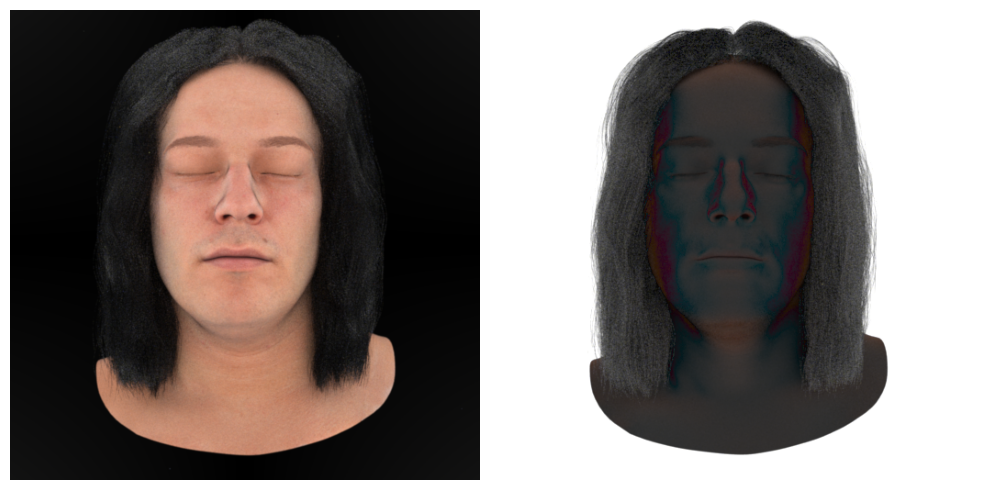

In [15]:
scene = mi.load_file("../scenes/marcus_light_sphere_hair.xml", res=512)

img_0, img_90 = render_from_angle(scene, 75, 0.5 * np.pi, 0, spp=256)

indirect, direct = separate(img_0, img_90)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(np.clip(indirect, 0, 1) ** (1.0 / 2.2))

plt.subplot(1, 2, 2)
plt.axis("off")
plt.imshow(np.clip(direct, 0, 1) ** (1.0 / 2.2))

plt.tight_layout()
plt.show()

Rendering:   0%|          | 0/4 [00:00<?, ?it/s]drjit.gather(): out-of-bounds read from position 2300000 in an array of size 2300000. (util.py:357)
drjit.gather(): out-of-bounds read from position 2300000 in an array of size 2300000. (util.py:357)
drjit.gather(): out-of-bounds read from position 2300000 in an array of size 2300000. (util.py:357)
drjit.gather(): out-of-bounds read from position 2300000 in an array of size 2300000. (util.py:357)
Rendering:  25%|██▌       | 1/4 [00:10<00:31, 10.66s/it]drjit.gather(): out-of-bounds read from position 2300000 in an array of size 2300000. (util.py:357)
drjit.gather(): out-of-bounds read from position 2300000 in an array of size 2300000. (util.py:357)
drjit.gather(): out-of-bounds read from position 2300000 in an array of size 2300000. (util.py:357)
drjit.gather(): out-of-bounds read from position 2300000 in an array of size 2300000. (util.py:357)
Rendering: 100%|██████████| 4/4 [00:42<00:00, 10.71s/it]


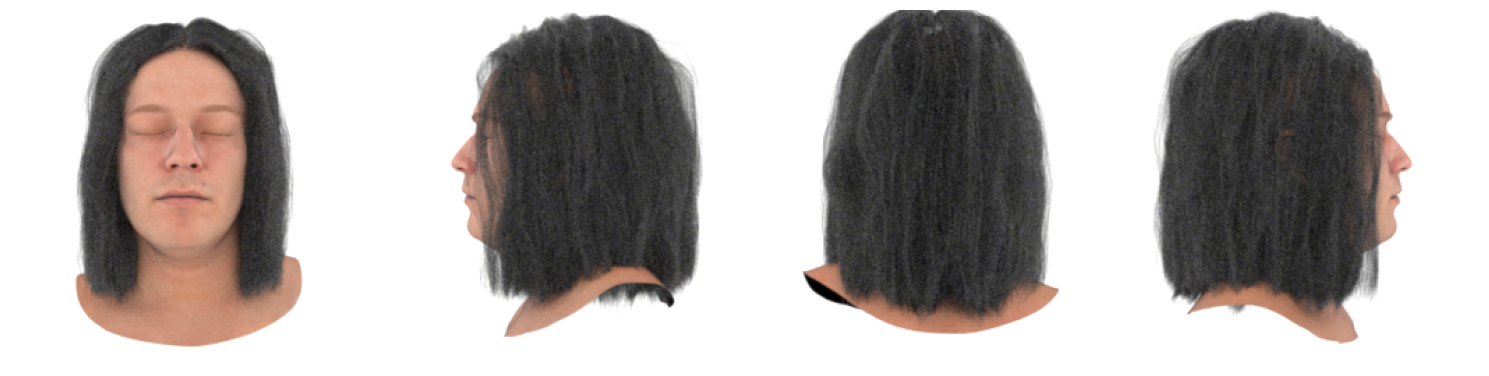

In [14]:
dr.set_flag(dr.JitFlag.Debug, True)

scene = mi.load_file("../scenes/marcus_light_sphere_hair.xml", res=256)

params = mi.traverse(scene)
params["polarizer_cam.to_world"] = mi.Transform4f().translate([10000, 10000, 10000])

# new_indices = [i for i in range(params["hair.control_point_count"]) if (i+1)%16 != 0]
# dr_indices = dr.cuda.ad.UInt32(new_indices)
# params["hair.segment_indices"] = dr_indices
params.update()

thetas = np.array([0.5*np.pi]*4)
phis = np.linspace(0, 2 * np.pi, 4, endpoint=False)
radius = 75

imgs = render_from_angles(scene, radius, thetas, phis, polarized=False, spp=256)

plt.figure(figsize=(15,4))

for i, img in enumerate(imgs):
	plt.subplot(1, 4, i+1)
	plt.axis("off")
	plt.imshow(np.clip(img, 0, 1) ** (1.0 / 2.2))

plt.tight_layout()
plt.show()

In [9]:
params = mi.traverse(scene)
print(params)

new_indices = [i for i in range(params["hair.control_point_count"]) if (i+1)%16 != 0]
dr_indices = dr.cuda.ad.UInt32(new_indices)
params["hair.segment_indices"] = dr_indices
params.update()

print(params["hair.control_point_count"])
segment_indices = params["hair.segment_indices"]
print(type(segment_indices))
print(len(segment_indices))
print(segment_indices[-1])
print(" ".join([str(segment_indices[i]) for i in range(60)]))



SceneParameters[
  -------------------------------------------------------------------------------------------------------
  Name                                                Flags    Type              Parent
  -------------------------------------------------------------------------------------------------------
  sensor.near_clip                                             float             PerspectiveCamera
  sensor.far_clip                                              float             PerspectiveCamera
  sensor.shutter_open                                          float             PerspectiveCamera
  sensor.shutter_open_time                                     float             PerspectiveCamera
  sensor.film.size                                             ScalarVector2u    HDRFilm
  sensor.film.crop_size                                        ScalarVector2u    HDRFilm
  sensor.film.crop_offset                                      ScalarPoint2u     HDRFilm
  sensor.x_fov      

_Kopf Dimensionen unskaliert:_

- x: -15,29; 15,29
- y: 0; 37,23
- z: -14,01; 14,01

Kopf macht ca. 2/3 der Höhe des Modells aus -> Höhe des Kopfes ungefähr 24 Einheiten

In [13]:
# Calculate Head Bounding Box
scene = mi.load_file("../scenes/marcus_light_sphere_hair.xml")
params = mi.traverse(scene)

positions = np.array(params["head.vertex_positions"]).reshape(-1, 3)
min_pos = positions.min(axis=0)
max_pos = positions.max(axis=0)

print(min_pos)
print(max_pos)

[-15.291506 -18.613869 -14.00991 ]
[15.288444 18.613873 14.014215]


_Haare Dimensionen unskaliert:_

- x: -30.90; 32.50
- y: -22.71; 63.58
- z: -33.90; 24.07

In [25]:
scene = mi.load_file("../scenes/marcus_light_sphere_hair.xml")
params = mi.traverse(scene)

positions = np.array(params["hair.control_points"]).reshape(-1, 4)
min_pos = positions.min(0)
max_pos = positions.max(0)

print(min_pos)
print(max_pos)

[-3.0898701e+01 -2.2708553e+01 -3.3900890e+01  9.7500003e-04]
[3.2495605e+01 6.3677959e+01 2.4073988e+01 9.7500003e-04]


_Haarfarbe:_

$$\sigma_a = (\ln(C) / (5.969 - 0.215 \beta_N + 2.532 \beta_N^2 - 10.73 \beta_N^3 + 5.574 \beta_N^4 + 0.245 \beta_N^5))^2$$

mit C = Farbe, $\beta_N$ = azimuthal roughness

Außerdem:

$$\sigma_s = \text{albedo} \cdot \sigma_t, \sigma_a = \sigma_t - \sigma_s$$

Also:

\begin{align*}
\sigma_a &= \sigma_t - \text{albedo} \cdot \sigma_t \\
\sigma_a &= \sigma_t \cdot (1 - \text{albedo}) \\
\frac{\sigma_a}{1 - \text{albedo}} &= \sigma_t
\end{align*}

In [3]:
def color_to_absorption(color, beta=0.3):
	return (np.log(color) / (5.969 - 0.215 * beta + 2.532 * beta ** 2 - 10.73 * beta ** 3 + 5.574 * beta ** 4 + 0.245 * beta ** 5 )) ** 2

def absorption_to_extinction(absorption, albedo):
	return absorption / (1 - albedo + 1e-6)

def calculate_extinction(color, scattering_albedo, beta=0.3):
	extinction = absorption_to_extinction(color_to_absorption(color, beta), scattering_albedo)
	print("Extinction:", ", ".join([str(i) for i in extinction]))


# straight Hair
print("straight Hair")
color = np.array([1.0, 0.925, 0.569])
albedo = 0.8
print(color, albedo)
absorption = color_to_absorption(color)
print(absorption)
extinction = absorption_to_extinction(absorption, albedo)
print(extinction)

# wWavy Hair
print("wWavy Hair")
color = np.array([0.4862745404243469, 0.43137258291244507, 0.3529411852359772])
albedo = 0.8
print(color, albedo)
absorption = color_to_absorption(color)
print(absorption)
extinction = absorption_to_extinction(absorption, albedo)
print(extinction)


straight Hair
[1.    0.925 0.569] 0.8
[0.         0.00017529 0.00916999]
[0.         0.00087646 0.0458497 ]
wWavy Hair
[0.48627454 0.43137258 0.35294119] 0.8
[0.01499174 0.02038784 0.03128119]
[0.07495831 0.10193868 0.15640517]
